# HemeFinder Knowledge-base scoring statistics

This notebook details the statistic calculations performed in order to obtain the necessary approximations to the PDF for the data distributions of geometrical descriptors (Malpha, Mbeta, angle) and volumes.

In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Volumes
Volumes seem to follow a standard normal distribution. So the central point of the distribution will be set up as the median value and the width as the standard deviation. First, however, the histogram of the data distribution will be displayed.

Text(0.5, 1.0, 'Volume Data Distribution')

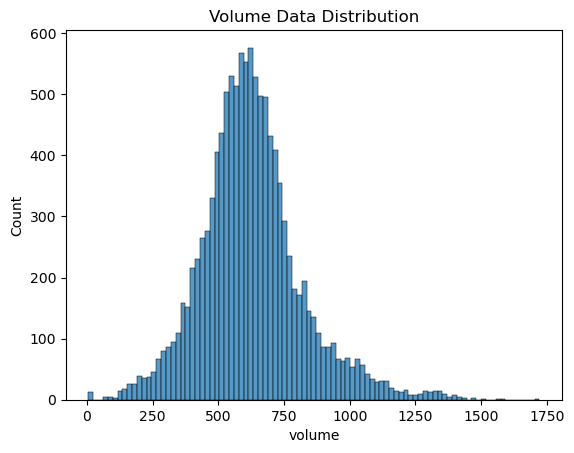

In [2]:
# Load data
data = pd.read_csv('output_volumes.csv')
sns.histplot(data, x='volume')
plt.title('Volume Data Distribution')

613.01 194.61793370605545


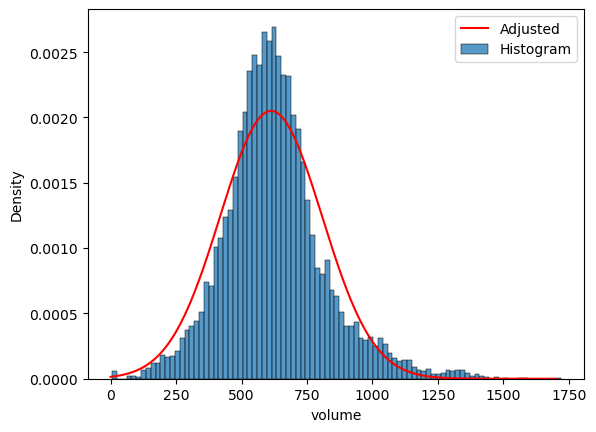

In [3]:
# Calculate statistics
nu = data['volume'].median()
sigma = data['volume'].std()
print(nu, sigma)

# Represent PDF
x = np.linspace(0, 1700, 3400)

# Define gaussian
def gaussian(x, nu, sigma):
    var = sigma**2
    denom = (2*np.pi*var)**.5
    num = np.exp(-(x-nu)**2/(2*var))
    return num / denom

y = gaussian(x, nu, sigma)
plt.plot(x, y, 'r')
sns.histplot(data, x='volume', stat='density')
plt.legend(['Adjusted', 'Histogram'])

## 2. Coordination analysis

In [4]:
coor_data = pd.read_csv('heme_coordination_stats.csv')
coor_data['site_name'].nunique()

9020

There are only 9020 binding sites in our dataset.

In [7]:
coor_data['metal_residue_name'].value_counts()

HEM    8639
HEC    2760
HEA     183
HDD      93
SRM      78
DHE      47
FEC      46
HAS      35
HEB      30
HDE      21
FDE      19
MH0      12
NTE       4
WVP       4
VEA       3
ISW       3
HKL       3
FMI       3
1FH       2
HEV       2
HDM       2
HCO       2
FDD       2
HME       2
HFM       2
2FH       2
7HE       1
6HE       1
POR       1
HE6       1
HEO       1
CLN       1
HIF       1
CCH       1
OBV       1
UFE       1
522       1
Name: metal_residue_name, dtype: int64

Text(0.5, 1.0, 'Alpha Distances General')

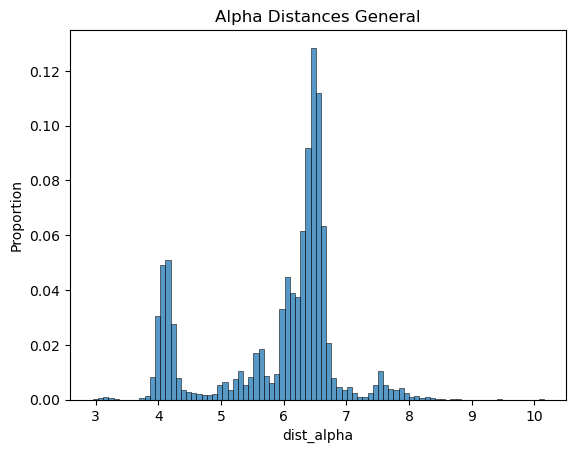

In [11]:
sns.histplot(coor_data, x='dist_alpha', stat='proportion')
plt.title('Alpha Distances General')

Text(0.5, 1.0, 'Beta Distances General')

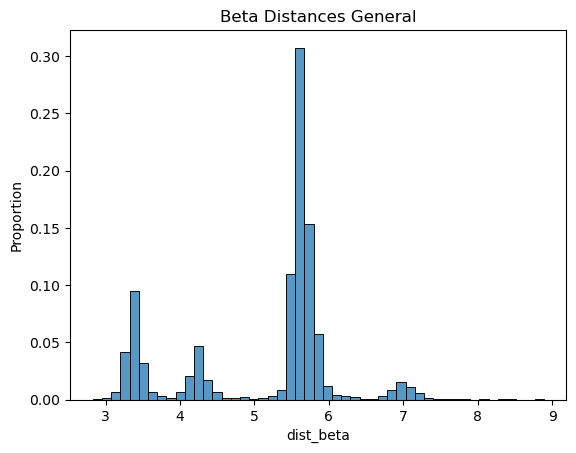

In [12]:
sns.histplot(coor_data, x='dist_beta', stat='proportion')
plt.title('Beta Distances General')

Text(0.5, 1.0, 'Angles General')

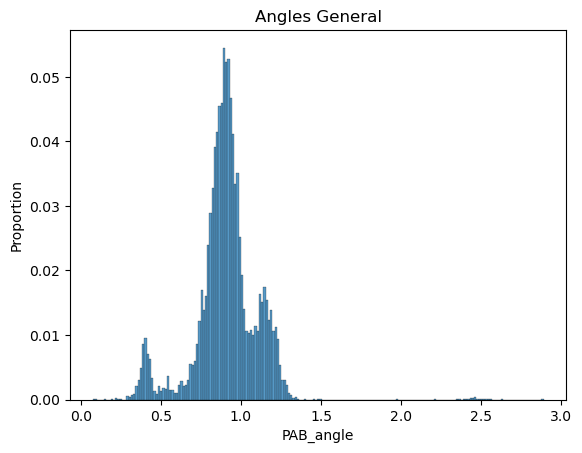

In [13]:
sns.histplot(coor_data, x='PAB_angle', stat='proportion')
plt.title('Angles General')

### 2.0. Functions for fitting bimodal function

In [88]:
import os
import json
import scipy.optimize as optimize
from brigit.utils.data import RESNAME2LETTER_DICT, ALL_METALS
from sklearn.neighbors import KernelDensity
import statsmodels.api as sm

def _normpdf(x: np.array or float, nu: float, std: float):
    """
    Helper function for `double_gaussian`, computes the PDF of a
    gaussian function.
    Args:
        x (np.array or float): Set of input values to evaluate.
        nu (float): Average value for the gaussian.
        std (float): Standard deviation of the gaussian.
    Returns:
        result (float): PDF value.
    """

    var = std ** 2
    num = np.exp(- (x - nu) ** 2 / (2 * var))
    return num

def bimodal(x, chi1, nu1, sigma1, chi2, nu2, sigma2, *args):
    first_gaussian = _normpdf(x, nu1, sigma1)
    second_gaussian = _normpdf(x, nu2, sigma2)
    return chi1 * first_gaussian + chi2 * second_gaussian

def fit(data, residue, experiment, data_path, p0, method):
    res_data = data[data['residue_name'] == residue]
    try:
        with open(data_path) as reader:
            output = json.load(reader)
    except FileNotFoundError:
        output = {}
    try:
        os.mkdir(f'figures/{residue}/{experiment}')
    except FileExistsError:
        pass
    except FileNotFoundError:
        os.mkdir(f'figures/{residue}')

    if len(res_data) < 5:
        return
    
    fun = bimodal
    res_data = res_data[np.isfinite(res_data[experiment])]
    if len(res_data) < 50:
        num_bins = 10 if len(res_data) > 10 else 5
    else:
        num_bins = len(res_data) // 10
    hist, bins = np.histogram(res_data[experiment], num_bins)
    hist = (hist - hist.min()) / (hist.max() - hist.min()) #hist.sum()
    dens = sm.nonparametric.KDEMultivariate(
        data=res_data[experiment], var_type='c'
    )
    x = np.linspace(0, 10, 512) # restrict range to (0,1)
    if experiment == 'PAB_angle':
        x = np.linspace(-np.pi, np.pi, 512)
    y = dens.pdf(x)
    y = ((y - y.min()) / (y.max() - y.min()))
    
    popt, pcov = optimize.curve_fit(
        f=fun,
        xdata=x,
        ydata=y,
        p0=p0,
        method=method,
        maxfev=int(10e3)
    )
    y_gaussian = fun(x, *popt)
    residuals = y - y_gaussian
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)
    plt.title(f'{residue} {experiment} R^2 = {round(r_squared, 3)}; n = {len(res_data)}')
    plt.stairs(hist, bins)
    plt.plot(x, y_gaussian)
    exp = experiment.split('_')[1]
    try:
        output[residue][experiment] = popt.tolist()
    except KeyError:
        output[residue] = {}

    plt.legend(['Real', 'Approximate PDF'])
    plt.savefig(f'figures/{residue}/{experiment}.png')

    plt.show()

    with open(data_path, 'w') as writer:
        json.dump(output, writer, indent=4, sort_keys=True)

### 2.1. Alpha distances coordination

In [131]:
coor_data['residue_name'].value_counts() / len(coor_data)

HIS    0.658784
CYS    0.186095
MET    0.101665
TYR    0.043797
LYS    0.006245
GLU    0.001332
SER    0.000500
PRO    0.000416
ALA    0.000333
TRP    0.000250
ASP    0.000250
GLY    0.000167
GLN    0.000083
ARG    0.000083
Name: residue_name, dtype: float64

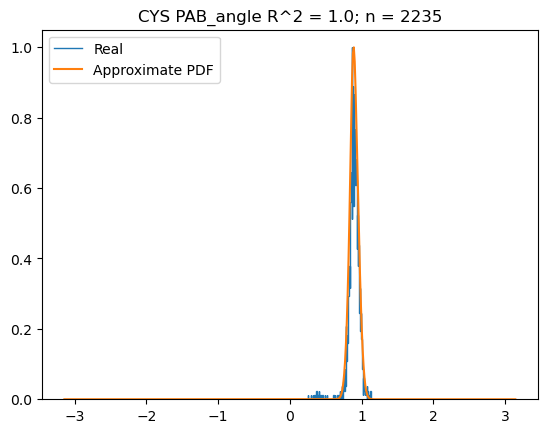

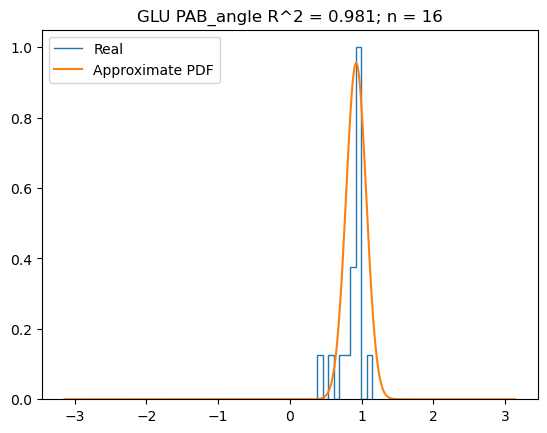

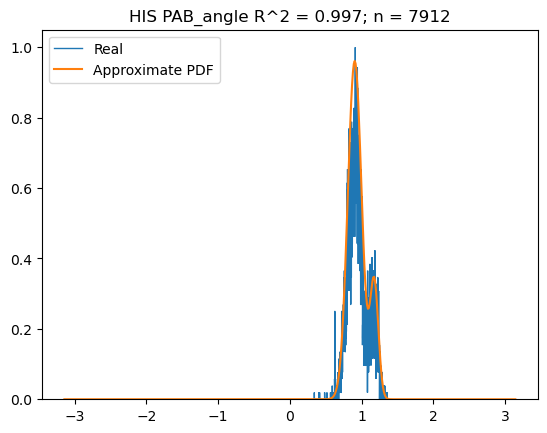

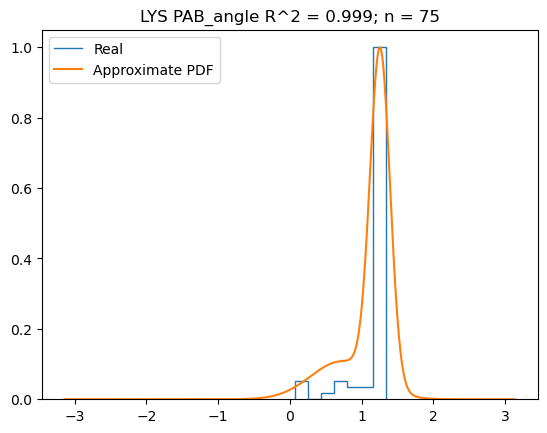

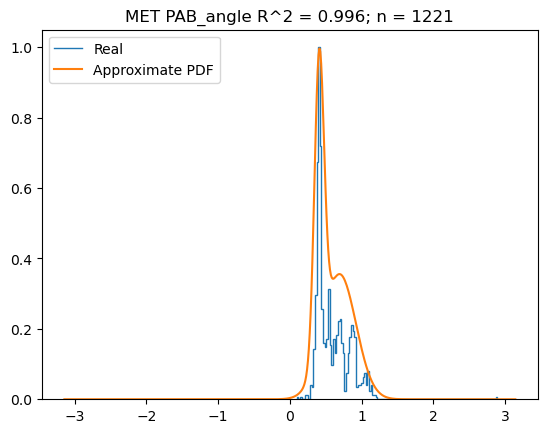

/home/rfernandez/miniconda3/envs/brigit/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


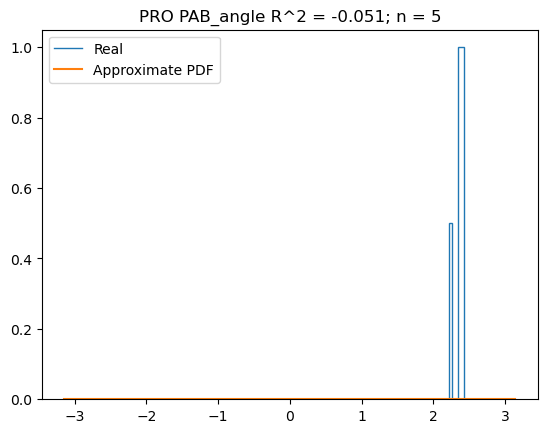

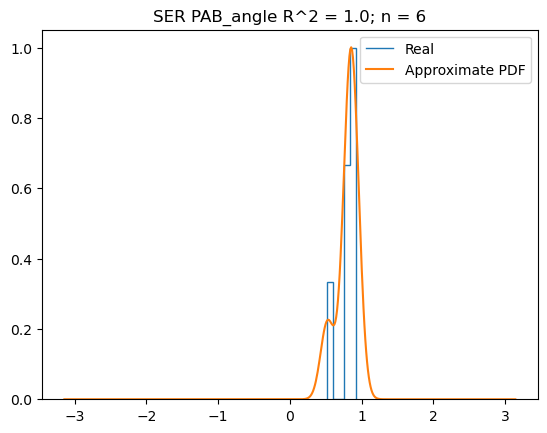

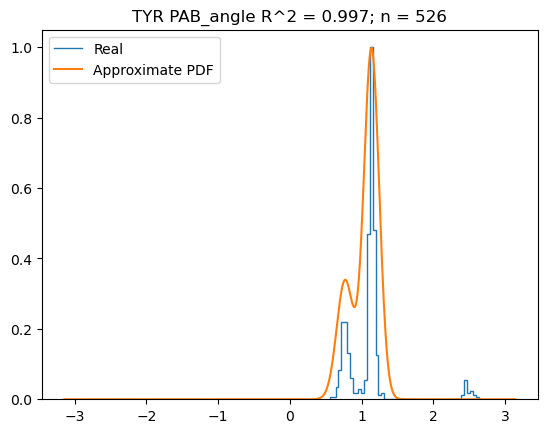

In [125]:
experiment = 'PAB_angle'
method = 'lm'
from brigit.utils.data import RESNAME2LETTER_DICT
for residue in sorted(RESNAME2LETTER_DICT.keys()):
    data_path = 'heme_gaus_statistics.json'
    p0 = [0.5, 0, .1, 0, 1, .1]
    fit(coor_data, residue, experiment, data_path, p0, method)

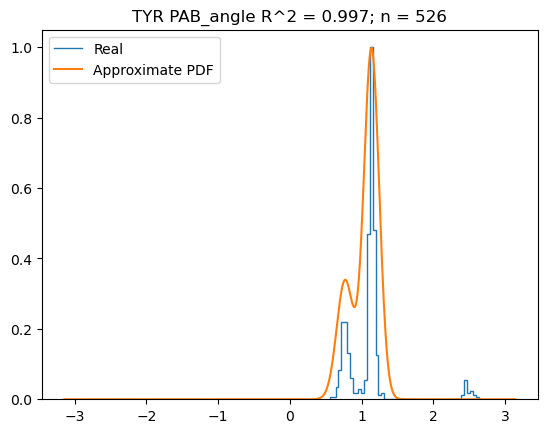

In [130]:
experiment = 'PAB_angle'
method = 'lm'
residue = 'tyr'.upper()
data_path = 'heme_gaus_statistics.json'
p0 = [1, 1, .1, 0, 0.8, .1]
fit(coor_data, residue, experiment, data_path, p0, method)